In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import mlxtend as ml
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Folgende Fragen sollen mithilfe der Verkaufsdaten beantwortet werden.

1) Was war der Monat mit dem höchsten Umsatz und wie hoch war dieser?

2) In welcher Stadt wurden die höchsten Umsätze erzielt und in welcher die niedrigsten?

3) Zu welcher Zeit sollten Marketingmaßnahmen getroffen werden um die Wahrscheinlichkeit zu erhöhen, dass Kunden das Produkt kaufen.

4) Welche Produkte wurden häufig zusammen gekauft? (Warenkorbanalyse)

5) Welches Produkt wurde am häufigsten verkauf? Wie beeinflusst der Preis den Absatz?

6) Gibt es Ähnlichkeitsstrukturen in den Verkäufen ? (Clusteranalyse)

## Zuerst werden die Daten aufbereitet.

In [19]:
# Verbinden von den 12 einzelen Monaten(CSV) zu einem einzelnen und lesen in DataFrame

files = [file for file in os.listdir("Sales_Data")]


alle_monate = pd.DataFrame()

for file in files:
    df = pd.read_csv("./Sales_Data/"+file)
    alle_monate = pd.concat([alle_monate,df])
    
#Entfernen von Duplikaten die durch das Zusammenfügen entstanden sind.
alle_monate.drop_duplicates(keep = False, inplace=True)
    
alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


In [20]:
# Betrachten und entfernen von NaN Werten

nan_df = alle_monate[alle_monate.isna().any(axis=1)]
#print(nan_df)

alle_monate = alle_monate.dropna(how="all")

#Die Einträge rausfiltern welche als Datums eintrag "or" haben (duplicate)
alle_monate = alle_monate[alle_monate["Order Date"].str[0:2] != "Or"]

***Damit die Fragen beanwortet werden können, müssen noch zusätzliche Features erstellt werden.
Eins für den Umsatz einer Bestellung und eins für den genauen Monat in dem die Bestellung getätig wurden ist. Zudem sollten noch die passenden Datentypen ausgewählt werden***

In [21]:
alle_monate.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object

In [22]:
# Erstellen von features für Monate

alle_monate["Monat"] = alle_monate["Order Date"].str[0:2]
alle_monate["Monat"] = alle_monate['Monat'].astype(str).astype(int)


# Umwandeln der features in passenden Typ
alle_monate["Quantity Ordered"] =  pd.to_numeric(alle_monate["Quantity Ordered"])
alle_monate["Price Each"]= pd.to_numeric(alle_monate["Price Each"])


# Erstellen von Umsatz feature
alle_monate["Umsatz"] = alle_monate["Quantity Ordered"] * alle_monate["Price Each"]
alle_monate.head()

# Umwandeln in Date Foramat von Pandas
alle_monate["Order Date"]= pd.to_datetime(alle_monate["Order Date"])
alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99


In [23]:
alle_monate.dtypes

Order ID                    object
Product                     object
Quantity Ordered             int64
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
Monat                        int32
Umsatz                     float64
dtype: object

### Deskriptive und Visuelle analyse der Daten.

In [24]:
alle_monate.describe()

,Quantity Ordered,Price Each,Monat,Umsatz
count,185422.000000,185422.000000,185422.000000,185422.000000
mean,1.124705,184.639117,7.058165,185.733300
std,0.443345,332.956586,3.502868,333.144702
min,1.000000,2.990000,1.000000,2.990000
25%,1.000000,11.950000,4.000000,11.950000
50%,1.000000,14.950000,7.000000,14.950000
75%,1.000000,150.000000,10.000000,150.000000
max,9.000000,1700.000000,12.000000,3400.000000


In [25]:
# Daten unterteilen in Numerisch und Kategorische 
alle_monate_kat = alle_monate[["Product","Purchase Address"]]
alle_monate_num = alle_monate[["Quantity Ordered","Price Each","Monat","Umsatz"]]

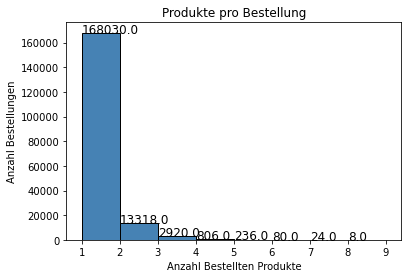

In [26]:
# Untersuchung der Numerischen Daten
  
your_bins=8
data=[alle_monate["Quantity Ordered"].sort_values()]
arr=plt.hist(data,bins=your_bins, color="Steelblue", edgecolor="black")
for i in range(your_bins):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]), fontsize = 12, ha="left")
plt.title("Produkte pro Bestellung") 
plt.ylabel("Anzahl Bestellungen")
plt.xlabel("Anzahl Bestellten Produkte")
plt.show()

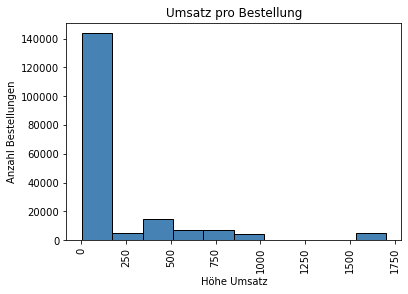

In [27]:
data=[alle_monate["Price Each"].sort_values().round()]
plt.hist(data, color="Steelblue", edgecolor="black")
plt.xticks(rotation="vertical")
plt.title("Umsatz pro Bestellung") 
plt.ylabel("Anzahl Bestellungen")
plt.xlabel("Höhe Umsatz")
plt.show()

plt.show()

Die Meisten Verkäufe beinhalten nur 1 Produkt und Kosten unter 250 Dollar

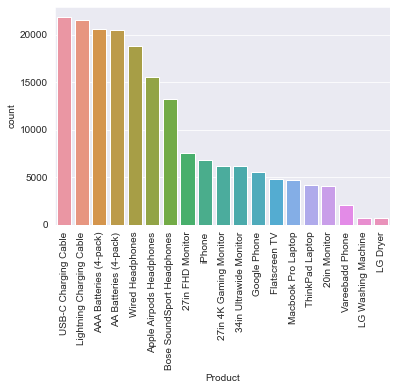

In [28]:
#Welche Produkte wurden wie oft Verkauft?
#Gruppieren der Produkte

data = alle_monate_kat
#print(data)


sns.set_style("darkgrid")
g = sns.countplot(x='Product', data=data, order=data['Product'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

Kleinere Produkte wie USB-C Kabel und Batterien wurden häufiger gekauft. Vermutlich teurere Produkte wie Waschmachine und Trockner seltener. Wird später noch genauer betrachtet.

## Frage 1. Was war der Monat mit dem höchsten Umsatz und wie viel wurde erziehlt?

In [29]:
# Um diese Frage zu beantworten sollten die zuvor erstelle Variable Monate gruppiert werden und anschließen die Umsätze Summiert werden.
results = alle_monate.groupby("Monat").sum().round() 
#print(results)

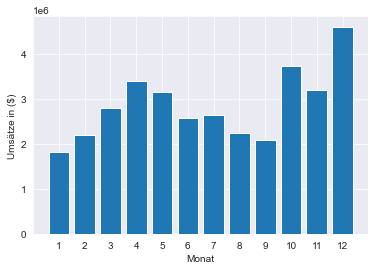

In [30]:
month = range(1,13)
plt.bar(month, results["Umsatz"]) 
plt.xticks(month)
plt.ylabel("Umsätze in ($)")
plt.xlabel("Monat")
plt.show()

Im Balkendiagramm ist zu sehen, dass die Umsätze im Dezember am höchsten sind. Der darauf folgende Januar hat hingegen die niedrigsten Umsätze.

## Frage 2. In welcher Stadt werden die höchsten Umsätze erziehlt?

In [31]:
# Um diese Frage zu beantworten wird der Stadt name aus der Spalte "Purchase Address" benötigt. Da die Käuferadresse immer gleich aufgebaut ist können wir sie nach dem Komma unerteilen.
# Anschließend damit eine neue Spalte erstellen die nur den Stadtnamen und den Bundesstaat enthält.

def get_city(adress):
    return adress.split(",")[1]

def get_state(adress):
    return adress.split(",")[2].split(" ")[1]

alle_monate["Stadt"] = alle_monate['Purchase Address'].apply(lambda x: get_city(x)+ " "+ get_state(x) )

alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz,Stadt
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90,Dallas TX
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99,Boston MA
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles CA
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles CA
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99,Los Angeles CA


In [32]:
# Nachdem die Variabel Stadt erstellt wurde kann sie gruppiert werden und die Umsätze summiert.

results = alle_monate.groupby("Stadt").sum().round()

#print(results)

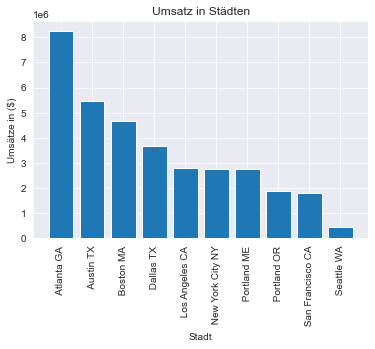

In [33]:
#Visualisierung der Städte mit dem höchsten Umsatz

#cities = alle_monate["Stadt"].unique()
stadt = [stadt for stadt, df in alle_monate.groupby("Stadt")]

plt.bar(stadt, results["Umsatz"].sort_values(ascending=False)) 
plt.xticks(stadt, rotation="vertical")
plt.ylabel("Umsätze in ($)")
plt.xlabel("Stadt")
plt.title("Umsatz in Städten")
plt.show()

Von den 10 Städten in die Produkte verkauft wurden, hat Atlanta den größten Umsatz. Gefolgt von Austin und Boston. Den niedrigsten Umsatz gab es in der Stadt Seattle

## Frage 3. Zu welcher Zeit sollten Marketingmaßnahmen getroffen werden um die Wahrscheinlichkeit zu erhöhen, dass Kunden das Produkt kaufen.

In [34]:
# Betrachten der Verkäufe zu bestimmten Uhrzeiten. Um diese Frage zu beantworten wird wieder ein Feature erstellt. Mithilfe der Pandas Funktionen für die Zeit transformation

alle_monate["Stunde"] = alle_monate["Order Date"].dt.hour
alle_monate["Minute"] = alle_monate["Order Date"].dt.minute
alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz,Stadt,Stunde,Minute
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90,Dallas TX,8,46
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99,Boston MA,22,30
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles CA,14,38
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,14,38
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,9,27


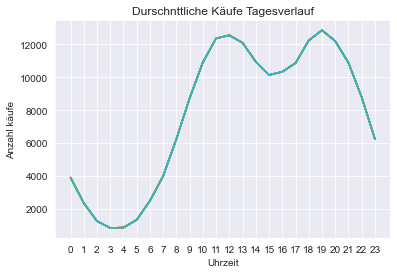

In [35]:
Stunden = [stunde for stunde, df in alle_monate.groupby(["Stunde"])]

plt.plot(Stunden, alle_monate.groupby(["Stunde"]).count())
plt.xticks(Stunden)
plt.ylabel("Anzahl käufe")
plt.xlabel("Uhrzeit")
plt.title("Durschnttliche Käufe Tagesverlauf")
plt.show()
#alle_monate.groupby(["Stunde"]).count()

Zu sehen sind Peaks um ca. 11-12 und um 19 Uhr. Die Aktion die Käufe anregen sollen können dementsprechend angepasst werden.

## Frage 4. Welche Produkte werden zusammengekauf?

In [36]:
# Produkte die zur selben Bestellung gehören wurden zusammnen gekauft. Warekenkorb analyse mit aprior Algorithmus.


# Alle Produkte die die selben Order ID  haben wurden zusammengekauft.
df = alle_monate[alle_monate["Order ID"].duplicated(keep = False)]
#print(df["Order ID"].describe())
#df.head()



df["grouped"] = df.groupby("Order ID")["Product"].transform(lambda x: ",".join(x)) #ckeck out transform
#print(df["grouped"])


#Transformation des Kategorischen features "Products" in Binäre Matrix(Sparse Matrix)
df = df[["Order ID", "grouped"]].drop_duplicates()

dummy = df["grouped"].str.get_dummies(sep=',')


dummy.head()

<ipython-input-36-306112a8f9c7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["grouped"] = df.groupby("Order ID")["Product"].transform(lambda x: ",".join(x)) #ckeck out transform


,20in Monitor,27in 4K Gaming Monitor,27in FHD Monitor,34in Ultrawide Monitor,AA Batteries (4-pack),AAA Batteries (4-pack),Apple Airpods Headphones,Bose SoundSport Headphones,Flatscreen TV,Google Phone,LG Dryer,LG Washing Machine,Lightning Charging Cable,Macbook Pro Laptop,ThinkPad Laptop,USB-C Charging Cable,Vareebadd Phone,Wired Headphones,iPhone
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
18,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
32,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
119,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
129,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


In [37]:

# Verwenden des apriori Algorithmus

frequent_itemsets = apriori(dummy, min_support=0.05, use_colnames=True) #min_support filtert "unwichtige" Regeln
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values('confidence', ascending = False, inplace = True)
rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(Vareebadd Phone),(USB-C Charging Cable),0.087431,0.293715,0.053535,0.612313,2.084714,0.027855,1.821790
3,(Google Phone),(USB-C Charging Cable),0.237416,0.293715,0.144748,0.609681,2.075755,0.075015,1.809508
6,(Lightning Charging Cable),(iPhone),0.250800,0.270585,0.146494,0.584107,2.158683,0.078631,1.753852
7,(iPhone),(Lightning Charging Cable),0.270585,0.250800,0.146494,0.541398,2.158683,0.078631,1.633660
2,(USB-C Charging Cable),(Google Phone),0.293715,0.237416,0.144748,0.492818,2.075755,0.075015,1.503571
0,(Apple Airpods Headphones),(iPhone),0.134711,0.270585,0.054262,0.402808,1.488656,0.017812,1.221408
10,(Wired Headphones),(iPhone),0.233634,0.270585,0.067210,0.287671,1.063146,0.003992,1.023987
4,(Wired Headphones),(Google Phone),0.233634,0.237416,0.061245,0.262142,1.104145,0.005777,1.033510
5,(Google Phone),(Wired Headphones),0.237416,0.233634,0.061245,0.257966,1.104145,0.005777,1.032791
11,(iPhone),(Wired Headphones),0.270585,0.233634,0.067210,0.248387,1.063146,0.003992,1.019629


* Wenn ein Vareebadd Phone gekauft wurde ist es ca. 2,1 mal so Wahrscheinlich, dass ein USB-C Ladegerät dazugekauft wird. Alledings ist der Support für diese Regel mit 0,05 gering.
* Etwas höher ist der Support (0,15) für die assoziations regel, Google Phone führt mit 2,08 höher wahrscheinlichkeit zum kauf eines Lightning Charging Cable.
* Allgeimein ist zu sehen, dass Handyzubehör(Ladekabel, Kopfhöhrer) jeweils zum passenden Betriebssysstem gekauft wird (Android, Apple). Daher kann es von nutzen sein diese Produkte mit jeweils zueinader zu empfehlen (Recommender Systems).

## Frage 5. Welches Produkt wurde am häufigsten verkauf? Wie beeinflusst der Preis den Absatz?

In [38]:
#Summieren der gekauften Produkte gruppiert nach Produkten

alle_monate.head()

product_group = alle_monate.groupby("Product")
quantity_ordered = product_group.sum()['Quantity Ordered']

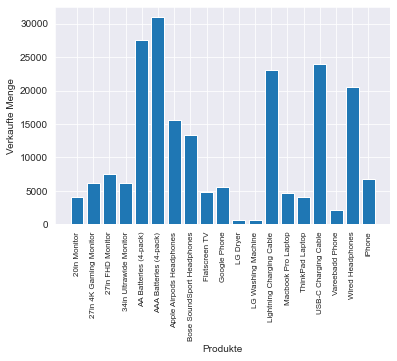

In [39]:
# Plotting Balkendiagramm

products = [product for product, df in product_group]

plt.bar(products, quantity_ordered)
plt.ylabel("Verkaufte Menge")
plt.xlabel("Produkte")
plt.xticks(products,rotation="vertical", size=8)

plt.show()

<ipython-input-40-3fff07c39a82>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(products, rotation="vertical", size=8)


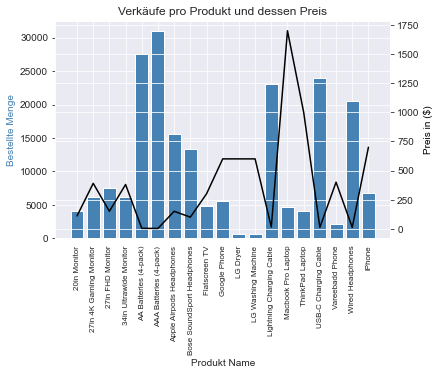

In [40]:
Preise = alle_monate.groupby("Product").mean()["Price Each"]

fig , ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered, color="Steelblue")
ax2.plot(products, Preise, "black")

ax1.set_xlabel("Produkt Name")
ax1.set_ylabel("Bestellte Menge", color="Steelblue")
ax2.set_ylabel("Preis in ($)", color="black")

ax1.set_xticklabels(products, rotation="vertical", size=8)
plt.title("Verkäufe pro Produkt und dessen Preis")
plt.show()

* Zu sehen ist, dass Produkte mit geringen Preis einen höheren Absatz haben. 
* Allerdings gibt es auch Ausnahmen. So haben teure Elektronic Produkte (Macbook, Thinpad und Iphone) einen höheren Preis werden dennoch relativ häufig bestellt.
* Fortsetzend is noch zu sehen, dass die Podukte LG Dryer und LG Waschmachine kaum gekauft werden.

## Frage 6. Gibt es Ähnlichkeitsstrukturen ein den Verkäufen ? (Clusteranalyse)

To cluster your data, you'll follow these steps:

    Prepare data.
    Create similarity metric.
    Run clustering algorithm.
    Interpret results and adjust your clustering.


In [41]:
alle_monate.head(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz,Stadt,Stunde,Minute
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90,Dallas TX,8,46
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99,Boston MA,22,30
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles CA,14,38
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,14,38
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,9,27
6,176562,USB-C Charging Cable,1,11.95,2019-04-29 13:03:00,"381 Wilson St, San Francisco, CA 94016",4,11.95,San Francisco CA,13,3
7,176563,Bose SoundSport Headphones,1,99.99,2019-04-02 07:46:00,"668 Center St, Seattle, WA 98101",4,99.99,Seattle WA,7,46
8,176564,USB-C Charging Cable,1,11.95,2019-04-12 10:58:00,"790 Ridge St, Atlanta, GA 30301",4,11.95,Atlanta GA,10,58
9,176565,Macbook Pro Laptop,1,1700.00,2019-04-24 10:38:00,"915 Willow St, San Francisco, CA 94016",4,1700.00,San Francisco CA,10,38
10,176566,Wired Headphones,1,11.99,2019-04-08 14:05:00,"83 7th St, Boston, MA 02215",4,11.99,Boston MA,14,5


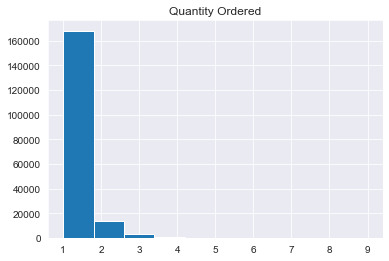

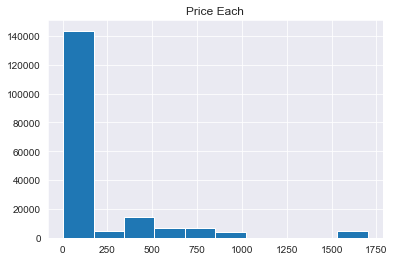

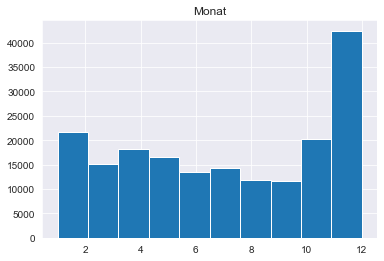

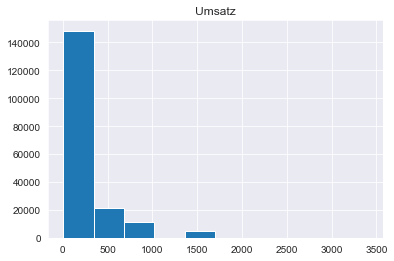

In [42]:
# Verteilung der Numerischen features
df_num = alle_monate_num
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [43]:
# Die Verteilung von "Quantity Ordered" hat eine gewisse ähnlichkeit zu einer Pareto-Verteilung

alle_monate["Quantity_Ordered_norm"]= np.log(alle_monate['Quantity Ordered'])


In [44]:
# Umwandeln in verschiedende Bins, alle bins haben gleich viele Einträge (Quantile normalization).


alle_monate["Price_Each_norm"] = pd.qcut(df_num["Price Each"],20,duplicates='drop',labels=False)
alle_monate["Umsatz_norm"] = pd.qcut(df_num["Umsatz"],20,duplicates='drop',labels=False)
alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz,Stadt,Stunde,Minute,Quantity_Ordered_norm,Price_Each_norm,Umsatz_norm
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,23.90,Dallas TX,8,46,0.693147,1,5
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,99.99,Boston MA,22,30,0.000000,4,6
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,600.00,Los Angeles CA,14,38,0.000000,9,11
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,14,38,0.000000,2,3
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,11.99,Los Angeles CA,9,27,0.000000,2,3


In [45]:
# Scale Anpassen alle features sollen zwischen[0-1] liegen
colsQuantiles = ["Price_Each_norm", "Quantity_Ordered_norm", "Umsatz_norm" ,"Quantity_Ordered_norm","Stunde","Monat"]

def minMaxScaler(numArr):
  minx = np.min(numArr)
  maxx = np.max(numArr)
  numArr = (numArr - minx) / (maxx - minx)
  return numArr


for string in colsQuantiles:
  alle_monate[string] = minMaxScaler(alle_monate[string])

alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz,Stadt,Stunde,Minute,Quantity_Ordered_norm,Price_Each_norm,Umsatz_norm
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",0.272727,23.90,Dallas TX,0.347826,46,0.315465,0.090909,0.384615
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",0.272727,99.99,Boston MA,0.956522,30,0.000000,0.363636,0.461538
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",0.272727,600.00,Los Angeles CA,0.608696,38,0.000000,0.818182,0.846154
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",0.272727,11.99,Los Angeles CA,0.608696,38,0.000000,0.181818,0.230769
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",0.272727,11.99,Los Angeles CA,0.391304,27,0.000000,0.181818,0.230769


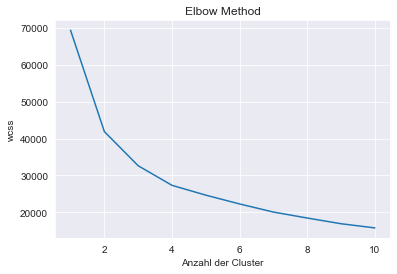

In [46]:
#Verwendung der elbow Method um die optimale Anzahl an Clustern zu finden. Basierend auf Within-Cluster-Sum-of-Squares

# Entfernen von Features die nicht für Cluster verwendet werden sollen
df = alle_monate[[ "Price_Each_norm", "Quantity_Ordered_norm", "Umsatz_norm" ,"Quantity_Ordered_norm","Stunde","Monat"]]

wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(df)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Anzahl der Cluster')
plt.ylabel('wcss')
plt.show()

In [47]:
# Nach Betrachtund des "Elbow" wird die optimale Clusteranzahl auf 3 gesetzt.

# Erstellung der Cluster mit k-means++
km = KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km.fit(df)

# Cluster den Label zuordnen
labels = y_means.labels_

# Einfügen der Cluster in Original df
alle_monate['Cluster'] = pd.Series(labels, index=alle_monate.index)
alle_monate.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Monat,Umsatz,Stadt,Stunde,Minute,Quantity_Ordered_norm,Price_Each_norm,Umsatz_norm,Cluster
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",0.272727,23.90,Dallas TX,0.347826,46,0.315465,0.090909,0.384615,2
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",0.272727,99.99,Boston MA,0.956522,30,0.000000,0.363636,0.461538,2
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",0.272727,600.00,Los Angeles CA,0.608696,38,0.000000,0.818182,0.846154,1
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",0.272727,11.99,Los Angeles CA,0.608696,38,0.000000,0.181818,0.230769,2
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",0.272727,11.99,Los Angeles CA,0.391304,27,0.000000,0.181818,0.230769,2


In [48]:
#Gruppieren der Cluster um zu sehen was die bestimmenden Eigenschaften sind.
alle_monate.drop(columns=["Minute","Quantity_Ordered_norm" ,"Price_Each_norm", "Umsatz_norm"], inplace=True)

#alle_monate.head()
alle_monate.groupby(by=["Cluster"]).mean()

,Quantity Ordered,Price Each,Monat,Umsatz,Stunde
Cluster,,,,,
0,1.191327,21.006301,0.854041,22.110319,0.627411
1,1.004916,475.234993,0.551370,476.291526,0.626213
2,1.192673,21.515531,0.285111,22.640778,0.626396


* Cluster 1 unterscheided sich von den andren beiden Clustern darin, dass die dazugehötigen Verkäufe einen Höheren Umsatz haben. Zusätzlich ist auch der einzelne Verkaufspreis höher

* Cluster 0 und 2 unterscheiden sich kaum voneinander. Sie variiren nur in dem Monat, wann die Käufe getätigt wurden.

* Nützlich wären noch zusätliche Kundendaten, damit die Einkäufe welche für einen hohen Umsatz sorgen (Cluster 1) noch bestimmten Kunden zugeordnet werden können.

